In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.neighbors import NearestNeighbors

import math
import os
from matplotlib import pyplot as plt
import functools as ft
import numpy as np
from collections import Counter
import seaborn as sn
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset
import torch.optim as optim

from utils import train, evaluate
from plots import *
from etl import *
from sklearn import tree

df = pd.read_csv('../data/psychotic-patient-data-p2.csv')
# print(df.info())
df.head()

,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,shizopherania,vascula_demetia,ADHD,Bipolar,agecode
0,M,18,Yes,C,STUDENT,Yes,S,Yes,No,No,Yes,N,P ø¬>,P,P,N,1
1,F,30,Yes,M,ARTISAN,Yes,S,Yes,No,Yes,Yes,P,P,P ­>,N,N,1
2,M,22,Yes,C,STUDENT,No,S,No,No,No,Yes,P,P,P ­>,N,P,1
3,M,35,No,M,ARTISAN,No,M,No,No,No,Yes,P,P,N ­>,N,P,2
4,M,30,Yes,M,ARTISAN,Yes,M,No,No,No,Yes,P,P,P,P,P,1


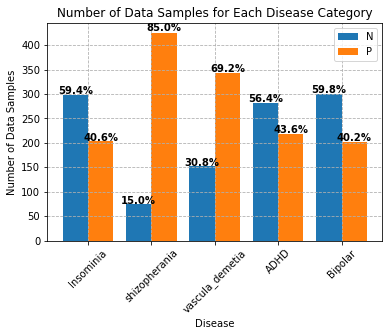

<Figure size 432x288 with 0 Axes>

In [8]:
def plot_data_distribution(df):
	# visualise data count for disease
	df_insomnia_count = (df['Insominia'].value_counts()).to_frame().reset_index()
	df_shizopherania_count = (df['shizopherania'].value_counts()).to_frame().reset_index()
	df_vascula_count = (df['vascula_demetia'].value_counts()).to_frame().reset_index()
	df_adhd_count = (df['ADHD'].value_counts()).to_frame().reset_index()
	df_bipolar_count = (df['Bipolar'].value_counts()).to_frame().reset_index()

	dfs_count = [df_insomnia_count, df_shizopherania_count, df_vascula_count, df_adhd_count, df_bipolar_count]
	df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='index'), dfs_count)

	category = ['Insominia', 'shizopherania', 'vascula_demetia', 'ADHD', 'Bipolar']
	N_count_list = ((df_final.iloc[0].to_frame().reset_index()).rename(columns={'index': 'category', 0: 'value'}).iloc[1:])['value'].tolist()
	P_count_list = ((df_final.iloc[1].to_frame().reset_index()).rename(columns={'index': 'category', 1: 'value'}).iloc[1:])['value'].tolist()
	P_count_percent = []
	N_count_percent = []
	for i in range(len(P_count_list)):
		value = 100.0 * P_count_list[i] / (P_count_list[i] + N_count_list[i])
		value = round(value,2)
		P_count_percent.append(value)
		value = 100.0 * N_count_list[i] / (P_count_list[i] + N_count_list[i])
		value = round(value,2)
		N_count_percent.append(value)

	X_axis = np.arange(len(category))
	
	graph1 = plt.bar(X_axis - 0.2, N_count_list, 0.4, label = 'N')
	graph2 = plt.bar(X_axis + 0.2, P_count_list, 0.4, label = 'P')
	i = 0
	for p in graph1:
		width = p.get_width()
		height = p.get_height()
		x, y = p.get_xy()
		plt.text(x+width/2,
				y+height*1.01,
				str(round(N_count_percent[i],1))+'%',
				ha='center',
				weight='bold', size= 10)
		i+=1

	i = 0
	for p in graph2:
		width = p.get_width()
		height = p.get_height()
		x, y = p.get_xy()
		plt.text(x+width/2,
				y+height*1.01,
				str(round(P_count_percent[i],1))+'%',
				ha='center',
				weight='bold', size= 10)
		i+=1

	plt.xticks(X_axis, category)
	plt.xlabel("Disease")
	plt.ylabel("Number of Data Samples")
	plt.title("Number of Data Samples for Each Disease Category")
	plt.xticks(rotation = 45)
	plt.grid(ls='--')
	plt.legend()
	plt.show()
	plt.savefig("../figure/DataSampleDistribution.png")
plot_data_distribution(df)

In [9]:
#clean data

#check for missing values
# print(df.isnull().sum()) # to verify

# remove extra letters in disease diagnosis
df['Insominia'] = df['Insominia'].astype(str).str[0]
df['shizopherania'] = df['shizopherania'].astype(str).str[0]
df['vascula_demetia'] = df['vascula_demetia'].astype(str).str[0]
df['ADHD'] = df['ADHD'].astype(str).str[0]
df['Bipolar'] = df['Bipolar'].astype(str).str[0]

#apply one hot encoding to categorical features
enc = OrdinalEncoder()
df[["sex", "faNoily_status", "religion" ,"occupation" , "genetic", "status", "loss_of_parent", "divorse", "Injury", "Spiritual_consult"]] = enc.fit_transform(df[["sex", "faNoily_status", "religion" ,"occupation" , "genetic", "status", "loss_of_parent", "divorse", "Injury", "Spiritual_consult"]])

# prepare output label into multiclass classification
label_dict = {'N': 0 , 'P': 1}
category = ['Insominia', 'shizopherania', 'vascula_demetia', 'ADHD', 'Bipolar']
for cat in category:
    df[cat+"_enc"] = df[cat].map(label_dict)
# df.drop(['Insominia', 'shizopherania', 'vascula_demetia', 'ADHD', 'Bipolar'], axis=1, inplace=True)

# create combined label
df["target"] = df['Insominia_enc'].astype(str) + df['shizopherania_enc'].astype(str) + df['vascula_demetia_enc'].astype(str) + df['ADHD_enc'].astype(str) + df['Bipolar_enc'].astype(str)

# count of multilabel
df_target_count = df['target'].value_counts()
print(df_target_count)
df_filter = df[~df['target'].isin(df_target_count[df_target_count < 7].index)]
df_target_count = df_filter['target'].value_counts().to_frame().reset_index() # to verify
print(df_target_count)

df_filter.head()

01110    101
01100     81
11101     72
11111     48
01010     47
01000     43
10101     23
11001     21
10001     19
00100     10
00000     10
11011      9
10111      5
10011      3
00110      2
11100      2
00010      2
01111      1
10100      1
Name: target, dtype: int64
    index  target
0   01110     101
1   01100      81
2   11101      72
3   11111      48
4   01010      47
5   01000      43
6   10101      23
7   11001      21
8   10001      19
9   00000      10
10  00100      10
11  11011       9


,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,...,vascula_demetia,ADHD,Bipolar,agecode,Insominia_enc,shizopherania_enc,vascula_demetia_enc,ADHD_enc,Bipolar_enc,target
0,1.0,18,1.0,0.0,4.0,1.0,1.0,1.0,0.0,0.0,...,P,P,N,1,0,1,1,1,0,01110
2,1.0,22,1.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,...,P,N,P,1,1,1,1,0,1,11101
3,1.0,35,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,N,N,P,2,1,1,0,0,1,11001
4,1.0,30,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,P,P,P,1,1,1,1,1,1,11111
5,0.0,86,1.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,...,P,N,N,3,0,1,1,0,0,01100


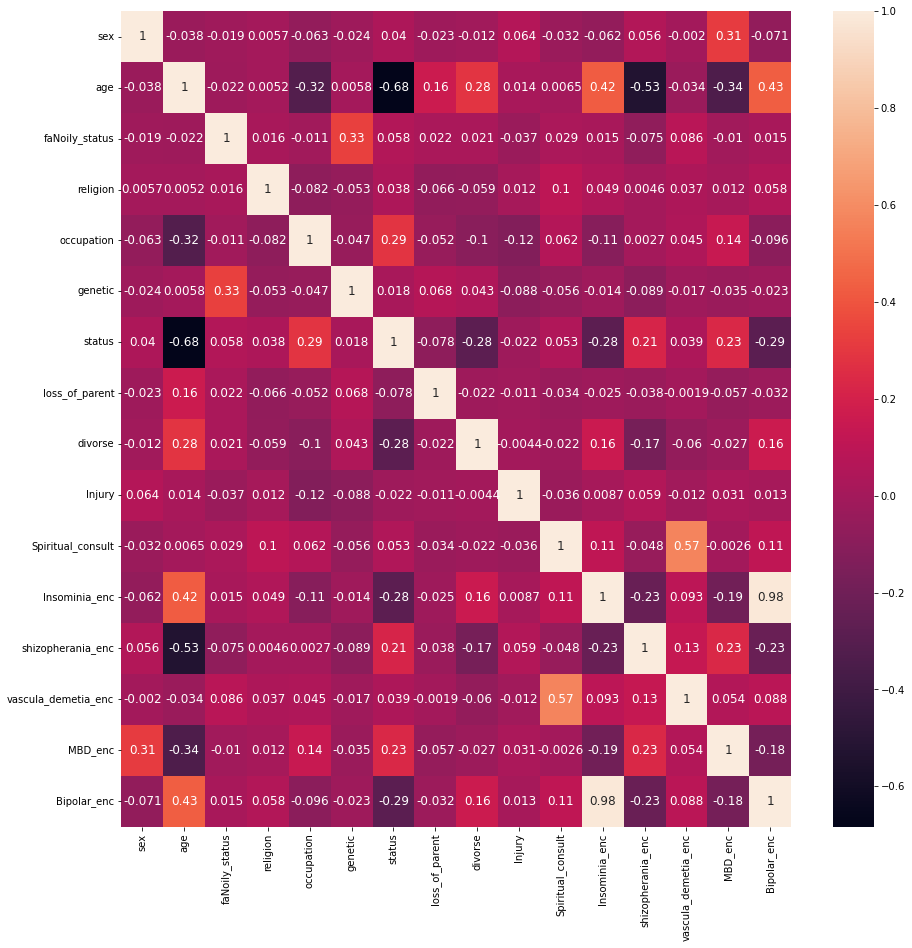

In [4]:
# Figure 9 correlation
df_1 = df.drop(['Insominia', 'shizopherania', 'vascula_demetia', 'ADHD', 'Bipolar', 'target', 'agecode'], axis=1)
feature_names = df_1.columns.tolist()

corrMatrix = df_1.corr()
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True, xticklabels=feature_names, yticklabels=feature_names, annot_kws={"fontsize":12})
plt.show()

In [23]:
target_dict = {}
target_list = df_target_count['index'].values
for i in range(len(target_list)):
    target_dict[target_list[i]] = i
print(target_dict)

def prepare_data(df_target_count, df_filter, smote=False):
    if smote is True:
        # prepare dataset with SMOTE applied
        max_target_sample = df_target_count['target'].max()
        target_list = df_target_count['index'].tolist() #target list for oversample to max_target_sample
        Y_smote = np.empty((0))
        X_smote =  np.empty((0, 11)) #hardcode no of features

        for target in target_list:
            df1 = df_filter.loc[df_filter['target'] == target]

            # split features and target
            X = df1.drop(['Insominia', 'shizopherania', 'vascula_demetia', 'ADHD', 'Bipolar', 'Insominia_enc', 'shizopherania_enc', 'vascula_demetia_enc', 'ADHD_enc', 'Bipolar_enc', 'target', 'agecode'], axis=1)
            feature_category = X.columns.tolist()

            X_array = X.to_numpy()
            Y = [target] * max_target_sample

            sm = SMOTE(X_array, k_neigh = 5, random_state = 123).fit()
            samples = sm.sample(max_target_sample)
            # print(samples.shape, len(Y), target)

            # append to final X features and Y target
            X_smote = np.append(X_smote, samples, 0)
            Y_smote = np.append(Y_smote, Y, 0)
        return X_smote, Y_smote, feature_category
        
    else:
        # prepare dataset without SMOTE applied
        X = df_filter.drop(['Insominia', 'shizopherania', 'vascula_demetia', 'ADHD', 'Bipolar', 'Insominia_enc', 'shizopherania_enc', 'vascula_demetia_enc', 'ADHD_enc', 'Bipolar_enc', 'target', 'agecode'], axis=1)
        feature_category = X.columns.tolist()
        
        X = X.to_numpy()
        Y = df_filter['target'].values
        return X, Y, feature_category

X, Y, feature_category  = prepare_data(df_target_count, df_filter, smote=False)
# Y = np.vectorize(target_dict.get) # convert to one hot label
Y_arr = []
for y_val in Y:
    Y_arr.append(np.array(list(map(int, y_val))))
Y = (np.array(Y_arr))
print(Y)


{'01110': 0, '01100': 1, '11101': 2, '11111': 3, '01010': 4, '01000': 5, '10101': 6, '11001': 7, '10001': 8, '00000': 9, '00100': 10, '11011': 11}
[[0 1 1 1 0]
 [1 1 1 0 1]
 [1 1 0 0 1]
 ...
 [0 1 1 1 0]
 [0 1 0 0 0]
 [0 1 1 0 0]]


In [32]:
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_multilabel_classification

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=123)

def DT(X_train, X_valid, Y_train, Y_valid):
    print("Decision Tree Training and Testing")
    dt_clf =  MultiOutputClassifier(DecisionTreeClassifier(max_depth=5, random_state=123)).fit(X_train, Y_train)
    y_pred = dt_clf.predict(X_valid)
    y_train_pred = dt_clf.predict(X_train)
    print('DT Model accuracy score without hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('DT Model accuracy score without hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    param_grid = {
        "estimator__max_depth": np.arange(1,10,1),
        "estimator__min_samples_leaf": np.arange(1,20,1),
    }
    
    grid_cv = GridSearchCV(dt_clf, param_grid, cv=5)
    grid_cv.fit(X_train, Y_train)
    # print("Best parameters : ", grid_cv.best_params_)
    y_pred = grid_cv.predict(X_valid)
    y_train_pred = grid_cv.predict(X_train)
    print('DT Model accuracy score with hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('DT Model accuracy score with hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    print("DT Train Report : ", classification_report(Y_train,y_train_pred))
    print("DT Test Report : ", classification_report(Y_valid, y_pred))
    print("\n")
    return

def RF(X_train, X_valid, Y_train, Y_valid):
    print("Random Forest Training and Testing")
    clf = MultiOutputClassifier(RandomForestClassifier(max_depth=5, random_state=123)).fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    print('RF Model accuracy score without hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('RF Model accuracy score without hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    param_grid = {
        "estimator__max_depth": np.arange(2,8,1),
        "estimator__min_samples_leaf": np.arange(2,10,1),
    }

    grid_cv = GridSearchCV(clf, param_grid, cv=5)
    grid_cv.fit(X_train, Y_train)
    print("Best parameters : ", grid_cv.best_params_)
    y_pred = grid_cv.predict(X_valid)
    y_train_pred = grid_cv.predict(X_train)
    print('RF Model accuracy score with hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('RF Model accuracy score with hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    print("RF Train Report : ", classification_report(Y_train,y_train_pred))
    print("RF Test Report : ", classification_report(Y_valid, y_pred))
    print("\n")

def SVM(X_train, X_valid, Y_train, Y_valid):
    print("SVM Training and Testing")
    clf = MultiOutputClassifier(SVC(random_state=123)).fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    print('SVM Model accuracy score without hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('SVM Model accuracy score without hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    param_grid = {
        "estimator__C": np.arange(0.1,1.0,5),
        "estimator__kernel" : ["linear", "poly", "rbf", "sigmoid"]
    }

    grid_cv = GridSearchCV(clf, param_grid, cv=5)
    grid_cv.fit(X_train, Y_train)
    print("Best parameters : ", grid_cv.best_params_)
    y_pred = grid_cv.predict(X_valid)
    y_train_pred = grid_cv.predict(X_train)
    print('SVM Model accuracy score with hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('SVM Model accuracy score with hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    print("SVM Train Report : ", classification_report(Y_train,y_train_pred))
    print("SVM Test Report : ", classification_report(Y_valid, y_pred))
    print("\n")

def MLP(X_train, X_valid, Y_train, Y_valid):
    print("MLP Training and Testing")
    clf = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(100,),batch_size=16, random_state=123)).fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    print('Model accuracy score without hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('Model accuracy score without hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    lr_param = np.logspace(-5, -2, 5).tolist()
    alpha_param = np.logspace(-3, -1, 5).tolist()
    param_grid = {
                'estimator__solver' : ['adam','sgd', 'lbfgs'],
                'estimator__activation' : ['tanh','relu'],
                'estimator__learning_rate_init' : lr_param,
                'estimator__alpha' : alpha_param
                }


    grid_cv = GridSearchCV(clf, param_grid, cv=5)
    grid_cv.fit(X_train, Y_train)
    # print("Best parameters : ", grid_cv.best_params_)
    y_pred = grid_cv.predict(X_valid)
    y_train_pred = grid_cv.predict(X_train)
    print('Model accuracy score with hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('Model accuracy score with hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    print("Train Report : ", classification_report(Y_train,y_train_pred))
    print("Test Report : ", classification_report(Y_valid, y_pred))
    print("\n")

# DT(X_train, X_valid, Y_train, Y_valid)
# RF(X_train, X_valid, Y_train, Y_valid)
# MLP(X_train, X_valid, Y_train, Y_valid)
SVM(X_train, X_valid, Y_train, Y_valid)


SVM Training and Testing
SVM Model accuracy score without hyperparameter tuning on train: 30.23%
SVM Model accuracy score without hyperparameter tuning on valid: 29.90%
Best parameters :  {'estimator__C': 0.1, 'estimator__kernel': 'linear'}
SVM Model accuracy score with hyperparameter tuning on train: 40.31%
SVM Model accuracy score with hyperparameter tuning on valid: 44.33%
SVM Train Report :                precision    recall  f1-score   support

           0       0.72      0.57      0.63       159
           1       0.95      0.99      0.97       337
           2       0.88      0.87      0.87       276
           3       0.67      0.62      0.65       162
           4       0.72      0.57      0.63       159

   micro avg       0.84      0.78      0.81      1093
   macro avg       0.79      0.72      0.75      1093
weighted avg       0.83      0.78      0.80      1093
 samples avg       0.85      0.81      0.80      1093

SVM Test Report :                precision    recall  f1-s

/Users/wkarlina/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wkarlina/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


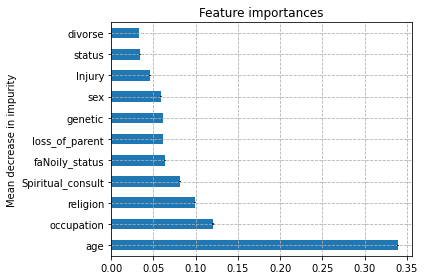

In [6]:
# feature importance with RF
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import time
import numpy as np
import pandas as pd

feature_names = feature_category
forest = RandomForestClassifier(random_state=123).fit(X, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
# print(forest_importances)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.grid(ls='--')
fig.tight_layout()



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_multilabel_classification

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=123)

X, Y = make_multilabel_classification(sparse = True, n_labels = 5,
return_indicator = 'sparse', allow_unlabeled = False)
print(X, Y)

def DT(X_train, X_valid, Y_train, Y_valid):
    print("Decision Tree Training and Testing")
    dt_clf = DecisionTreeClassifier(max_depth=5, random_state=123).fit(X_train, Y_train)
    y_pred = dt_clf.predict(X_valid)
    y_train_pred = dt_clf.predict(X_train)
    print('DT Model accuracy score without hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('DT Model accuracy score without hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    param_grid = {
        "max_depth": np.arange(1,10,1),
        "min_samples_leaf": np.arange(1,20,1),
    }

    grid_cv = GridSearchCV(dt_clf, param_grid, cv=5)
    grid_cv.fit(X_train, Y_train)
    # print("Best parameters : ", grid_cv.best_params_)
    y_pred = grid_cv.predict(X_valid)
    y_train_pred = grid_cv.predict(X_train)
    print('DT Model accuracy score with hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('DT Model accuracy score with hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    print("DT Train Report : ", classification_report(Y_train,y_train_pred))
    print("DT Test Report : ", classification_report(Y_valid, y_pred))
    print("\n")
    return

def RF(X_train, X_valid, Y_train, Y_valid):
    print("Random Forest Training and Testing")
    clf = RandomForestClassifier(max_depth=5, random_state=123).fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    print('RF Model accuracy score without hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('RF Model accuracy score without hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    param_grid = {
        "max_depth": np.arange(2,8,1),
        "min_samples_leaf": np.arange(2,10,1),
    }

    grid_cv = GridSearchCV(clf, param_grid, cv=5)
    grid_cv.fit(X_train, Y_train)
    print("Best parameters : ", grid_cv.best_params_)
    y_pred = grid_cv.predict(X_valid)
    y_train_pred = grid_cv.predict(X_train)
    print('RF Model accuracy score with hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('RF Model accuracy score with hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    print("RF Train Report : ", classification_report(Y_train,y_train_pred))
    print("RF Test Report : ", classification_report(Y_valid, y_pred))
    print("\n")

def SVM(X_train, X_valid, Y_train, Y_valid):
    print("SVM Training and Testing")
    clf = SVC(random_state=123).fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    print('SVM Model accuracy score without hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('SVM Model accuracy score without hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    param_grid = {
        "C": np.arange(0.1,1.0,5),
        "kernel" : ["linear", "poly", "rbf", "sigmoid"]
    }

    grid_cv = GridSearchCV(clf, param_grid, cv=5)
    grid_cv.fit(X_train, Y_train)
    print("Best parameters : ", grid_cv.best_params_)
    y_pred = grid_cv.predict(X_valid)
    y_train_pred = grid_cv.predict(X_train)
    print('SVM Model accuracy score with hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('SVM Model accuracy score with hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    print("SVM Train Report : ", classification_report(Y_train,y_train_pred))
    print("SVM Test Report : ", classification_report(Y_valid, y_pred))
    print("\n")

def MLP(X_train, X_valid, Y_train, Y_valid):
    print("MLP Training and Testing")
    clf = MLPClassifier(hidden_layer_sizes=(100,),batch_size=16, random_state=123).fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    print('Model accuracy score without hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('Model accuracy score without hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    lr_param = np.logspace(-5, -2, 5).tolist()
    alpha_param = np.logspace(-3, -1, 5).tolist()
    param_grid = {
                'solver' : ['adam','sgd', 'lbfgs'],
                'activation' : ['tanh','relu'],
                'learning_rate_init' : lr_param,
                'alpha' : alpha_param
                }


    grid_cv = GridSearchCV(clf, param_grid, cv=5)
    grid_cv.fit(X_train, Y_train)
    # print("Best parameters : ", grid_cv.best_params_)
    y_pred = grid_cv.predict(X_valid)
    y_train_pred = grid_cv.predict(X_train)
    print('Model accuracy score with hyperparameter tuning on train: %.2f%%' % (accuracy_score(Y_train, y_train_pred) * 100))
    print('Model accuracy score with hyperparameter tuning on valid: %.2f%%' % (accuracy_score(Y_valid, y_pred) * 100))

    print("Train Report : ", classification_report(Y_train,y_train_pred))
    print("Test Report : ", classification_report(Y_valid, y_pred))
    print("\n")

DT(X_train, X_valid, Y_train, Y_valid)


  (0, 0)	1.0
  (0, 1)	3.0
  (0, 2)	4.0
  (0, 4)	1.0
  (0, 5)	4.0
  (0, 6)	2.0
  (0, 7)	5.0
  (0, 8)	4.0
  (0, 9)	2.0
  (0, 10)	4.0
  (0, 11)	2.0
  (0, 12)	4.0
  (0, 14)	1.0
  (0, 15)	5.0
  (0, 16)	3.0
  (0, 17)	2.0
  (0, 18)	2.0
  (0, 19)	3.0
  (1, 0)	7.0
  (1, 2)	8.0
  (1, 3)	4.0
  (1, 4)	2.0
  (1, 5)	4.0
  (1, 7)	4.0
  (1, 8)	3.0
  :	:
  (98, 14)	1.0
  (98, 15)	2.0
  (98, 16)	4.0
  (98, 17)	2.0
  (98, 19)	1.0
  (99, 0)	4.0
  (99, 1)	4.0
  (99, 2)	3.0
  (99, 3)	2.0
  (99, 4)	8.0
  (99, 5)	4.0
  (99, 6)	3.0
  (99, 7)	1.0
  (99, 8)	4.0
  (99, 9)	2.0
  (99, 10)	1.0
  (99, 11)	1.0
  (99, 12)	2.0
  (99, 13)	2.0
  (99, 14)	4.0
  (99, 15)	1.0
  (99, 16)	1.0
  (99, 17)	3.0
  (99, 18)	5.0
  (99, 19)	1.0   (0, 1)	1
  (0, 2)	1
  (0, 4)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (1, 4)	1
  (2, 0)	1
  (2, 2)	1
  (2, 3)	1
  (2, 4)	1
  (3, 0)	1
  (3, 2)	1
  (3, 4)	1
  (4, 0)	1
  (4, 1)	1
  (4, 2)	1
  (4, 3)	1
  (5, 1)	1
  (5, 2)	1
  (5, 3)	1
  (5, 4)	1
  (6, 0)	1
  (6, 3)	1
  (7, 0)	1
  :	:
  (92, 2)	1
  

/Users/wkarlina/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wkarlina/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wkarlina/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wka

In [87]:
# prepare train dataset
NUM_EPOCHS = 10
BATCH_SIZE = 32
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

train_index = int(0.7* X.shape[0])
X_train = X[:train_index][:]
Y_train = Y[:train_index]
train_data = torch.tensor(X_train).to(torch.float32)
train_target = torch.tensor(Y_train.astype('long'))
train_dataset = TensorDataset(train_data, train_target)
# print(train_data.shape, train_target.shape)

X_valid = X[train_index:][:]
Y_valid = Y[train_index:]
valid_data = torch.tensor(X_valid).to(torch.float32)
valid_target = torch.tensor(Y_valid.astype('long'))
valid_dataset = TensorDataset(valid_data, valid_target)
# print(valid_data.shape, valid_target.shape)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Counter(Y_valid) # check count in validation target (does not match with figure 8 count)

/Users/wkarlina/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: [0][0/11]	Time 0.002 (0.002)	Data 0.001 (0.001)	Loss 2.5534 (2.5534)	Accuracy 0.000 (0.000)
Epoch: [0][10/11]	Time 0.001 (0.002)	Data 0.000 (0.001)	Loss 2.3386 (2.3223)	Accuracy 5.556 (13.905)
Test: [0/5]	Time 0.001 (0.001)	Loss 2.3385 (2.3385)	Accuracy 25.000 (25.000)
Epoch: [1][0/11]	Time 0.002 (0.002)	Data 0.001 (0.001)	Loss 2.4287 (2.4287)	Accuracy 3.125 (3.125)
Epoch: [1][10/11]	Time 0.001 (0.002)	Data 0.001 (0.001)	Loss 2.1351 (2.2234)	Accuracy 27.778 (20.414)
Test: [0/5]	Time 0.000 (0.000)	Loss 2.2220 (2.2220)	Accuracy 28.125 (28.125)
Epoch: [2][0/11]	Time 0.002 (0.002)	Data 0.001 (0.001)	Loss 2.2515 (2.2515)	Accuracy 18.750 (18.750)
Epoch: [2][10/11]	Time 0.002 (0.002)	Data 0.000 (0.001)	Loss 2.0196 (2.1749)	Accuracy 33.333 (24.852)
Test: [0/5]	Time 0.001 (0.001)	Loss 2.1697 (2.1697)	Accuracy 21.875 (21.875)
Epoch: [3][0/11]	Time 0.001 (0.001)	Data 0.000 (0.000)	Loss 2.1259 (2.1259)	Accuracy 25.000 (25.000)
Epoch: [3][10/11]	Time 0.010 (0.002)	Data 0.009 (0.001)	Loss 1.9

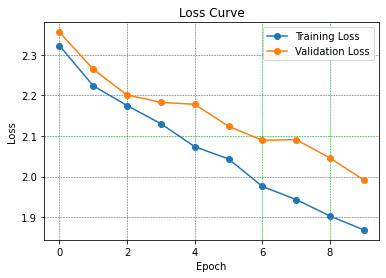

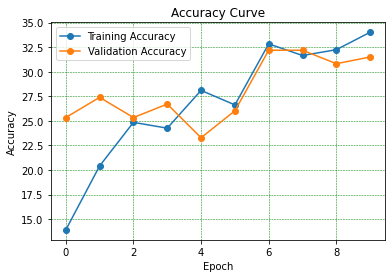

<Figure size 432x288 with 0 Axes>

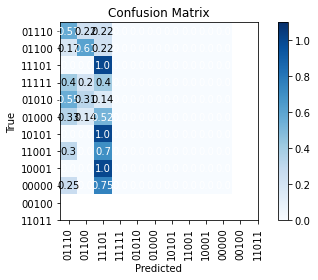

In [69]:
class MyMLP_A(nn.Module):
	def __init__(self):
		super(MyMLP_A, self).__init__()
		self.hidden1 = nn.Linear(11, 20)
		self.hidden2 = nn.Linear(20, 40)
		self.out = nn.Linear(40, 5)

	def forward(self, x):
		x = nn.functional.relu(self.hidden1(x))
		x = nn.functional.sigmoid(self.hidden2(x))
		x = self.out(x)
		return x

class MyMLP_B(nn.Module):
	def __init__(self):
		super(MyMLP_B, self).__init__()
		self.hidden1 = nn.Linear(11, 20)
		self.hidden2 = nn.Linear(20, 40)
		self.out = nn.Linear(40, 12)

	def forward(self, x):
		x = nn.functional.relu(self.hidden1(x))
		x = nn.functional.sigmoid(self.hidden2(x))
		x = self.out(x)
		return x

MODEL_TYPE = 'MLP_B'
PATH_OUTPUT = '../model/'
if MODEL_TYPE == 'MLP_A':
	model = MyMLP_A()
	save_file = 'MyMLP_A.pth'
elif MODEL_TYPE == 'MLP_B':
	model = MyMLP_B()
	save_file = 'MyMLP_B.pth'

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, os.path.join(PATH_OUTPUT, save_file))

plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_model = torch.load(os.path.join(PATH_OUTPUT, save_file))
valid_loss, valid_accuracy, valid_results = evaluate(best_model, device, valid_loader, criterion)
print("valid accuracy:", valid_accuracy)
class_names = df_target_count['index'].values
plot_confusion_matrix(valid_results, class_names)
